In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import libraries
import polars as pl
import numpy as np
import pandas as pd
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
#Path to data

#Path to training data
dataPath_train= '/content/drive/My Drive/credit/kaggle_credit/csv_files/train/'
#dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

#Path to testing data
dataPath_test= '/content/drive/My Drive/credit/kaggle_credit/csv_files/test/'
#dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

# Load data and Feature engineering

In [5]:
train_basetable = pd.read_csv(dataPath_train+'/train_base.csv')
train_basetable.head()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [ ]:
# get monthly annuity
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'annuity_780A': static['annuity_780A'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                   'annuity_780A': static2['annuity_780A'].values})
del static2
df=pd.concat([df, df2])
train_basetable['annuity_780A'] = df['annuity_780A'].values
#train_basetable.head()

<ipython-input-7-9cf20f3ddcaa>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-7-9cf20f3ddcaa>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


In [ ]:
# Calculate correlation matrix
correlation_matrix = train_basetable[['annuity_780A', 'target']].corr()
print(correlation_matrix)

              annuity_780A    target
annuity_780A      1.000000  0.004754
target            0.004754  1.000000


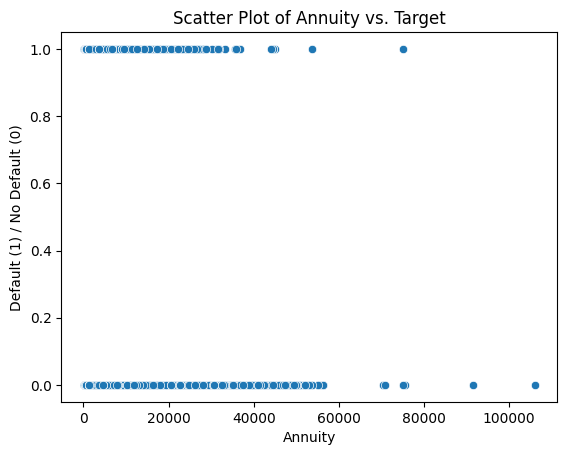

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter Plot
sns.scatterplot(x='annuity_780A', y='target', data=train_basetable)
plt.title('Scatter Plot of Annuity vs. Target')
plt.xlabel('Annuity')
plt.ylabel('Default (1) / No Default (0)')
plt.show()

There is a higher concentration of points at the 0 level, suggesting that for most annuity amounts, there was no default.

In [6]:
# Get main income
person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')
df = person_1.filter(['case_id','mainoccupationinc_384A'])
df = df.groupby('case_id').agg('max')
train_basetable['main income'] = df['mainoccupationinc_384A'].values


<ipython-input-6-99486c7448f4>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')


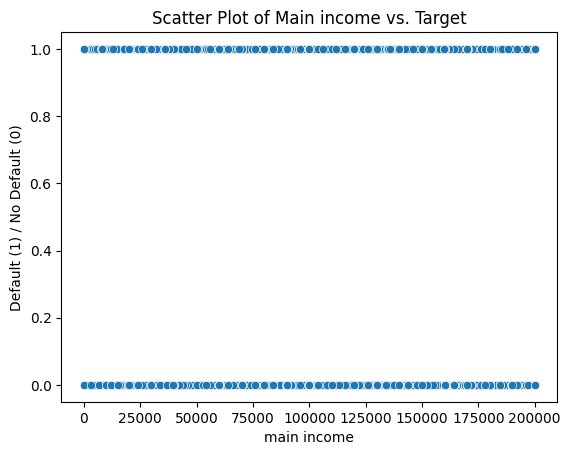

In [7]:
# Scatter Plot
sns.scatterplot(x='main income', y='target', data=train_basetable)
plt.title('Scatter Plot of Main income vs. Target')
plt.xlabel('main income')
plt.ylabel('Default (1) / No Default (0)')
plt.show()

In [8]:
# get primary income
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'maininc_215A': static['maininc_215A'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                   'maininc_215A': static2['maininc_215A'].values})
del static2
df=pd.concat([df, df2])
del df2
train_basetable['maininc_215A'] = df['maininc_215A'].values

<ipython-input-8-85752cf13d95>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-8-85752cf13d95>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


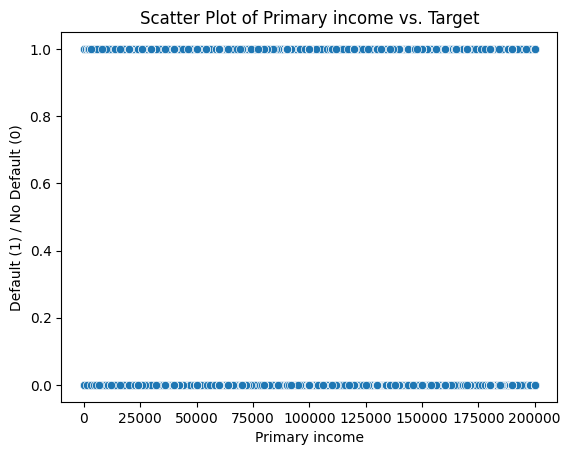

In [9]:
# Scatter Plot
sns.scatterplot(x='maininc_215A', y='target', data=train_basetable)
plt.title('Scatter Plot of Primary income vs. Target')
plt.xlabel('Primary income')
plt.ylabel('Default (1) / No Default (0)')
plt.show()

In [ ]:
# Get income  type
person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')
df = person_1.filter(['case_id','incometype_1044T','num_group1'])
train_basetable['income type'] = df[df['num_group1']==0]['incometype_1044T'].values
del df

<ipython-input-10-ec20a595a5fb>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')


In [ ]:
#Get many feautures
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
df = static[['case_id','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = static2[['case_id','numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithoutdpd_562L','numinstpaid_4499208L','numinsttopaygrest_4493213L','pmtnum_254L','totaldebt_9A','totalsettled_863A']]
del static2
df = pd.concat([df, df2])
del df2
for i in df.columns:
    if i != 'case_id':
        train_basetable[i] = df[i].values
del df

<ipython-input-11-4e3180fd4824>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
<ipython-input-11-4e3180fd4824>:5: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


In [ ]:
#get features from static_cb_0
static_cb = base = pd.read_csv(dataPath_train+'train_static_cb_0.csv')
train_basetable = train_basetable.merge(static_cb.filter(['case_id','numberofqueries_373L','riskassesment_302T']), on='case_id', how='left')

<ipython-input-12-129b31b262e2>:2: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb = base = pd.read_csv(dataPath_train+'train_static_cb_0.csv')


In [ ]:
# define function that extracts percentage
def get_prob(s):
    if pd.isna(s):
        return np.nan
    else:
        perc_1st = s.find('%')
        hyphen_blank = s.find(' - ')
        prob_1st = int(s[0: perc_1st])
        prob_2nd = int(s[hyphen_blank+3: len(s)-1])

        return 0.5*(prob_1st+prob_2nd)

In [ ]:
train_basetable['cb_risk_mean'] = train_basetable['riskassesment_302T'].apply(get_prob)

In [ ]:
# Get childnum and familystate
person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')
df = person_1.filter(['case_id','childnum_185L','familystate_447L','num_group1'])
train_basetable['familystate_447L'] = df[df['num_group1']==0]['familystate_447L'].values
df['childnum_185L']=df['childnum_185L'].fillna(0)
df2 = pd.DataFrame({'case_id': train_basetable['case_id'],
                    'childnum_185L': df.filter(['case_id','childnum_185L']).groupby('case_id').sum()['childnum_185L'].values})
train_basetable['childnum_185L']=df2['childnum_185L']
del df, df2

<ipython-input-15-a0f19ec4b2f7>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person_1 = pd.read_csv(dataPath_train+'train_person_1.csv')


In [ ]:
# Get avgmaxdpdlast9m_3716943P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'avgmaxdpdlast9m_3716943P': static['avgmaxdpdlast9m_3716943P'].values})
del static
static2 = pd.read_csv(dataPath_train+'/train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                   'avgmaxdpdlast9m_3716943P': static2['avgmaxdpdlast9m_3716943P'].values})
del static2
df=pd.concat([df, df2])
train_basetable['avgmaxdpdlast9m_3716943P'] = df['avgmaxdpdlast9m_3716943P'].values

<ipython-input-16-4f59d0ebaec4>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-16-4f59d0ebaec4>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'/train_static_0_1.csv')


In [ ]:
# GET WEIGHTED AVERAGE OF THE AVERAGE DAYS PAST DUE

# Merging: avgdbddpdlast24m_3658932P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'avgdbddpdlast24m_3658932P': static['avgdbddpdlast24m_3658932P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'avgdbddpdlast24m_3658932P': static2['avgdbddpdlast24m_3658932P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['avgdbddpdlast24m_3658932P'] = df['avgdbddpdlast24m_3658932P'].values


<ipython-input-17-5389df18caa0>:4: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-17-5389df18caa0>:9: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


In [ ]:
# Get: avgdbddpdlast3m_4187120P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'avgdbddpdlast3m_4187120P': static['avgdbddpdlast3m_4187120P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'avgdbddpdlast3m_4187120P': static2['avgdbddpdlast3m_4187120P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['avgdbddpdlast3m_4187120P'] = df['avgdbddpdlast3m_4187120P'].values



<ipython-input-18-666a229c73d7>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-18-666a229c73d7>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


In [ ]:
# Define the weights
weights = {
    'avgdbddpdlast24m_3658932P': 0.8,  # Higher weight for longer-term behavior
    'avgdbddpdlast3m_4187120P': 0.2    # Lower weight for more recent behavior
}

# Calculate the weighted average DPD and save in a new column
train_basetable['weighted_avg_dpd'] = (train_basetable['avgdbddpdlast24m_3658932P'] * weights['avgdbddpdlast24m_3658932P'] +
                                       train_basetable['avgdbddpdlast3m_4187120P'] * weights['avgdbddpdlast3m_4187120P']) / sum(weights.values())


In [ ]:
# Calculate correlation matrix
correlation_matrix = train_basetable[['avgdbddpdlast24m_3658932P', 'avgdbddpdlast3m_4187120P', 'weighted_avg_dpd', 'target']].corr()
print(correlation_matrix)

                           avgdbddpdlast24m_3658932P  \
avgdbddpdlast24m_3658932P                   1.000000   
avgdbddpdlast3m_4187120P                    0.723312   
weighted_avg_dpd                            0.990857   
target                                      0.000718   

                           avgdbddpdlast3m_4187120P  weighted_avg_dpd  \
avgdbddpdlast24m_3658932P                  0.723312          0.990857   
avgdbddpdlast3m_4187120P                   1.000000          0.809862   
weighted_avg_dpd                           0.809862          1.000000   
target                                     0.000568          0.000721   

                             target  
avgdbddpdlast24m_3658932P  0.000718  
avgdbddpdlast3m_4187120P   0.000568  
weighted_avg_dpd           0.000721  
target                     1.000000  


In [ ]:
# Get maxdbddpdtollast12m_3658940P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'maxdbddpdtollast12m_3658940P': static['maxdbddpdtollast12m_3658940P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'maxdbddpdtollast12m_3658940P': static2['maxdbddpdtollast12m_3658940P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['maxdbddpdtollast12m_3658940P'] = df['maxdbddpdtollast12m_3658940P'].values

<ipython-input-20-7c2169e77d85>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-20-7c2169e77d85>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


In [ ]:
#NOT USED TO TRAIN MLP
# Get maxdbddpdlast1m_3658939P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'maxdbddpdlast1m_3658939P': static['maxdbddpdlast1m_3658939P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'maxdbddpdlast1m_3658939P': static2['maxdbddpdlast1m_3658939P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['maxdbddpdlast1m_3658939P'] = df['maxdbddpdlast1m_3658939P'].values

# Get maxdbddpdtollast12m_3658940P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'maxdbddpdtollast12m_3658940P': static['maxdbddpdtollast12m_3658940P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'maxdbddpdtollast12m_3658940P': static2['maxdbddpdtollast12m_3658940P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['maxdbddpdtollast12m_3658940P'] = df['maxdbddpdtollast12m_3658940P'].values

# Get maxdbddpdtollast6m_4187119P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'maxdbddpdtollast6m_4187119P': static['maxdbddpdtollast6m_4187119P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'maxdbddpdtollast6m_4187119P': static2['maxdbddpdtollast6m_4187119P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['maxdbddpdtollast6m_4187119P'] = df['maxdbddpdtollast6m_4187119P'].values

# Fill NaN values with the average of each respective 'max' column
avg_value = train_basetable[['maxdbddpdtollast6m_4187119P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdlast1m_3658939P']].mean()
train_basetable[['maxdbddpdtollast6m_4187119P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdlast1m_3658939P']] = train_basetable[['maxdbddpdtollast6m_4187119P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdlast1m_3658939P']].fillna(avg_value)

# Define the weights
weights = {
    'maxdbddpdtollast12m_3658940P': 0.997,  # Higher weight for longer-term behavior
    'maxdbddpdtollast6m_4187119P': 0.002,   # Lower weight for more recent behavior
    'maxdbddpdlast1m_3658939P': 0.001       # Lower weight for more recent behavior
}

# Calculate the weighted average DPD and save in a new column
train_basetable['weighted_maxdbddpdlastxm'] = (train_basetable['maxdbddpdtollast12m_3658940P'] * weights['maxdbddpdtollast12m_3658940P'] +
                                               train_basetable['maxdbddpdtollast6m_4187119P'] * weights['maxdbddpdtollast6m_4187119P'] +
                                               train_basetable['maxdbddpdlast1m_3658939P'] * weights['maxdbddpdlast1m_3658939P']) / sum(weights.values())

# Calculate correlation matrix
correlation_matrix = train_basetable[['maxdbddpdtollast6m_4187119P', 'maxdbddpdtollast12m_3658940P', 'maxdbddpdlast1m_3658939P', 'weighted_maxdbddpdlastxm', 'target']].corr()
print(correlation_matrix)


<ipython-input-18-5ca48b027853>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-18-5ca48b027853>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
<ipython-input-18-5ca48b027853>:15: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-18-5ca48b027853>:20: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
<ipython-input-18-5ca48b027853>:28: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-18-5ca48b027853>:33: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


                              maxdbddpdtollast6m_4187119P  \
maxdbddpdtollast6m_4187119P                      1.000000   
maxdbddpdtollast12m_3658940P                     0.908986   
maxdbddpdlast1m_3658939P                         0.904100   
weighted_maxdbddpdlastxm                         0.909382   
target                                           0.000836   

                              maxdbddpdtollast12m_3658940P  \
maxdbddpdtollast6m_4187119P                       0.908986   
maxdbddpdtollast12m_3658940P                      1.000000   
maxdbddpdlast1m_3658939P                          0.897470   
weighted_maxdbddpdlastxm                          0.999999   
target                                            0.001011   

                              maxdbddpdlast1m_3658939P  \
maxdbddpdtollast6m_4187119P                   0.904100   
maxdbddpdtollast12m_3658940P                  0.897470   
maxdbddpdlast1m_3658939P                      1.000000   
weighted_maxdbddpdlastxm    

In [ ]:
# Get: posfpd30lastmonth_3976960P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'posfpd30lastmonth_3976960P': static['posfpd30lastmonth_3976960P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'posfpd30lastmonth_3976960P': static2['posfpd30lastmonth_3976960P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['posfpd30lastmonth_3976960P'] = df['posfpd30lastmonth_3976960P'].values

# Calculate correlation matrix
correlation_matrix = train_basetable[['posfpd30lastmonth_3976960P', 'target']].corr()
print(correlation_matrix)

<ipython-input-21-e89e907ac2c6>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003757 entries, 0 to 1003756
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.2+ GB


<ipython-input-21-e89e907ac2c6>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


                            posfpd30lastmonth_3976960P   target
posfpd30lastmonth_3976960P                     1.00000 -0.00025
target                                        -0.00025  1.00000


In [ ]:
# Get: posfstqpd30lastmonth_3976962P
static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
#static.info()
df = pd.DataFrame({'case_id': static['case_id'].values,
                   'posfstqpd30lastmonth_3976962P': static['posfstqpd30lastmonth_3976962P'].values})
del static
static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')
df2 = pd.DataFrame({'case_id': static2['case_id'].values,
                    'posfstqpd30lastmonth_3976962P': static2['posfstqpd30lastmonth_3976962P'].values})
del static2
df = pd.concat([df, df2])
train_basetable['posfstqpd30lastmonth_3976962P'] = df['posfstqpd30lastmonth_3976962P'].values

# Calculate correlation matrix
correlation_matrix = train_basetable[['posfstqpd30lastmonth_3976962P', 'posfpd30lastmonth_3976960P', 'target']].corr()
print(correlation_matrix)

<ipython-input-22-df897ff572e2>:2: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(dataPath_train+'train_static_0_0.csv')
<ipython-input-22-df897ff572e2>:7: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static2 = pd.read_csv(dataPath_train+'train_static_0_1.csv')


                               posfstqpd30lastmonth_3976962P  \
posfstqpd30lastmonth_3976962P                       1.000000   
posfpd30lastmonth_3976960P                          0.423302   
target                                              0.000351   

                               posfpd30lastmonth_3976960P    target  
posfstqpd30lastmonth_3976962P                    0.423302  0.000351  
posfpd30lastmonth_3976960P                       1.000000 -0.000250  
target                                          -0.000250  1.000000  


In [ ]:
# Get max dpd from previous applications
# read train_applprev_1_1
prev_apply = pd.read_csv(dataPath_train+'train_applprev_1_1.csv')

# fill NA with 0
df = prev_apply.filter(['case_id', 'actualdpd_943P'])
df['actualdpd_943P'] = df['actualdpd_943P'].fillna(0)

# group by max and join
df1 = pd.DataFrame({'case_id1': prev_apply.filter(['case_id', 'actualdpd_943P']).groupby('case_id').max().index.values,
                    'prevdpd_max': prev_apply.filter(['case_id', 'actualdpd_943P']).groupby('case_id').max()['actualdpd_943P']})
df2 = pd.DataFrame({'case_id1': train_basetable['case_id']})
df3 = pd.merge(df2, df1, on='case_id1', how='outer')
df3['prevdpd_max'] = df3['prevdpd_max'].fillna(0)

train_basetable['prevdpd_max'] = df3['prevdpd_max']
del df, df1, df2, df3, prev_apply


<ipython-input-23-7f30dc07895b>:3: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  prev_apply = pd.read_csv(dataPath_train+'train_applprev_1_1.csv')


In [ ]:
train_basetable.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,annuity_780A,main income,maininc_215A,income type,numinstlsallpaid_934L,...,familystate_447L,childnum_185L,avgmaxdpdlast9m_3716943P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,maxdbddpdtollast12m_3658940P,weighted_avg_dpd,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,prevdpd_max
0,0,2019-01-03,201901,0,0,1917.6,10800.0,NaN,SALARIED_GOVT,NaN,...,MARRIED,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
1,1,2019-01-03,201901,0,0,3134.0,10000.0,NaN,SALARIED_GOVT,NaN,...,DIVORCED,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
2,2,2019-01-04,201901,0,0,4937.0,14000.0,NaN,EMPLOYED,NaN,...,MARRIED,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
3,3,2019-01-03,201901,0,0,4643.6,10000.0,NaN,EMPLOYED,NaN,...,MARRIED,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
4,4,2019-01-04,201901,0,1,3390.2,24000.0,NaN,EMPLOYED,NaN,...,MARRIED,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0


In [ ]:
train_basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 30 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   case_id                        1526659 non-null  int64  
 1   date_decision                  1526659 non-null  object 
 2   MONTH                          1526659 non-null  int64  
 3   WEEK_NUM                       1526659 non-null  int64  
 4   target                         1526659 non-null  int64  
 5   annuity_780A                   1526659 non-null  float64
 6   main income                    1526659 non-null  float64
 7   maininc_215A                   1015404 non-null  float64
 8   income type                    1526659 non-null  object 
 9   numinstlsallpaid_934L          1080990 non-null  float64
 10  numinstlswithdpd10_728L        1070164 non-null  float64
 11  numinstlswithoutdpd_562L       1070164 non-null  float64
 12  numinstpaid_44

In [ ]:
train_basetable.drop(columns = ['date_decision','income type','riskassesment_302T','familystate_447L']).corr()

,case_id,MONTH,WEEK_NUM,target,annuity_780A,main income,maininc_215A,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithoutdpd_562L,...,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,weighted_avg_dpd,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,weighted_maxdbddpdlastxm,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,prevdpd_max
case_id,1.000000,0.133167,0.163464,0.003834,0.104237,0.020504,0.006038,0.060722,-0.022070,0.064259,...,0.000076,-0.005133,-0.000939,-0.006472,-0.004760,-0.007060,-0.004767,0.000914,0.008179,-0.005767
MONTH,0.133167,1.000000,0.835303,0.004875,-0.027198,-0.000295,0.006347,-0.037136,0.010702,-0.036747,...,0.003160,0.000899,0.002860,-0.000071,0.000662,-0.000218,0.000660,-0.000079,-0.005371,0.005864
WEEK_NUM,0.163464,0.835303,1.000000,0.002969,0.023188,0.013803,0.012042,0.014261,0.007924,0.014993,...,-0.005063,-0.004449,-0.005170,-0.003884,-0.005714,-0.005666,-0.005714,-0.002397,-0.003270,0.002742
target,0.003834,0.004875,0.002969,1.000000,0.004754,0.006057,0.002074,-0.000665,0.001069,-0.000473,...,0.000718,0.000568,0.000721,0.000971,0.001011,0.000836,0.001011,-0.000250,0.000351,0.001641
annuity_780A,0.104237,-0.027198,0.023188,0.004754,1.000000,0.030121,0.119117,0.090527,-0.052170,0.087820,...,-0.021916,-0.010968,-0.020761,-0.008848,-0.017176,-0.012571,-0.017165,-0.003601,-0.002631,-0.001985
main income,0.020504,-0.000295,0.013803,0.006057,0.030121,1.000000,0.019769,0.020362,-0.002883,0.020824,...,-0.001177,-0.000034,-0.001006,0.000745,-0.000003,0.000110,-0.000003,0.001158,0.000533,-0.003140
maininc_215A,0.006038,0.006347,0.012042,0.002074,0.119117,0.019769,1.000000,0.117893,-0.064673,0.126863,...,-0.090734,-0.028705,-0.085797,-0.012606,-0.042700,-0.027925,-0.042662,-0.001677,-0.000283,-0.000012
numinstlsallpaid_934L,0.060722,-0.037136,0.014261,-0.000665,0.090527,0.020362,0.117893,1.000000,0.040282,0.973183,...,-0.087053,-0.067767,-0.087195,-0.063468,-0.070918,-0.064004,-0.070917,-0.004173,-0.000899,-0.002850
numinstlswithdpd10_728L,-0.022070,0.010702,0.007924,0.001069,-0.052170,-0.002883,-0.064673,0.040282,1.000000,0.062027,...,0.147071,0.058346,0.136342,0.050158,0.116059,0.077647,0.115959,0.001479,0.003480,-0.000931
numinstlswithoutdpd_562L,0.064259,-0.036747,0.014993,-0.000473,0.087820,0.020824,0.126863,0.973183,0.062027,1.000000,...,-0.088695,-0.069206,-0.088871,-0.064513,-0.072083,-0.065291,-0.072083,-0.003499,-0.000118,-0.002923


In [ ]:
# Check which columns have NaN values
nan_columns = train_basetable.columns[train_basetable.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

Columns with NaN values: ['maininc_215A', 'numinstlsallpaid_934L', 'numinstlswithdpd10_728L', 'numinstlswithoutdpd_562L', 'numinstpaid_4499208L', 'numinsttopaygrest_4493213L', 'pmtnum_254L', 'totaldebt_9A', 'totalsettled_863A', 'numberofqueries_373L', 'riskassesment_302T', 'cb_risk_mean', 'familystate_447L', 'avgmaxdpdlast9m_3716943P', 'avgdbddpdlast24m_3658932P', 'avgdbddpdlast3m_4187120P', 'weighted_avg_dpd', 'maxdbddpdtollast12m_3658940P', 'posfpd30lastmonth_3976960P', 'posfstqpd30lastmonth_3976962P']


# Splitting training data and training the MLP

-)  Handling Numeric Features: type 'int64' or 'float64'.
* Median Imputation: Replace missing values in numeric columns with the median value of the column.
* Missing Indicators: Add a new feature indicating whether a value was missing in the original dataset.
* Standard Scaling: Scale features to have zero mean and unit variance.

-) Preprocessing Categorical Features: columns in the dataset that are of type 'object'.
* Constant Imputation: Replace missing values in categorical columns with a placeholder text ('missing').
* Missing Indicators: Add indicators for missing values to capture the presence of missing data.
* One-Hot Encoding: Convert categorical variables into a form that could be provided to ML algorithms to do a better job in prediction. It creates binary columns for each category and assigns a 1 or 0 (True/False).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define columns to exclude from the model
excluded_features = ['avgdbddpdlast3m_4187120P', 'case_id', 'target']

# Select features by excluding specified columns
X = train_basetable.drop(columns=excluded_features)
y = train_basetable['target']
# Select features by excluding specified columns
X = train_basetable.drop(columns=excluded_features)
y = train_basetable['target']

# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Define preprocessing for numeric columns (scale them and add missing indicators)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),  # Impute median and add missing indicators
    ('scaler', StandardScaler())])  # Standard scaling

# Define preprocessing for categorical features (encode them and add missing indicators)
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing', add_indicator=True)),  # Impute with 'missing' and add missing indicators
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # One-hot encoding

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create a full pipeline with the classifier
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state=1))
])

# Fit model on training data
full_pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = full_pipeline.predict_proba(X_valid)[:, 1]

# Calculate ROC AUC score
#roc_auc = roc_auc_score(y_valid, y_pred)
#print(f"Validation ROC AUC Score: {roc_auc}")

ROC AUC SCORES

In [ ]:
# Predict probabilities on the training, validation, and test sets
y_train_pred = full_pipeline.predict_proba(X_train)[:, 1]
y_valid_pred = full_pipeline.predict_proba(X_valid)[:, 1]
y_test_pred = full_pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# Print ROC AUC scores
print(f"Training ROC AUC Score: {roc_auc_train}")
print(f"Validation ROC AUC Score: {roc_auc_valid}")
print(f"Testing ROC AUC Score: {roc_auc_test}")

Training ROC AUC Score: 0.7963112370103307
Validation ROC AUC Score: 0.5947242876872081
Testing ROC AUC Score: 0.5914501713516093


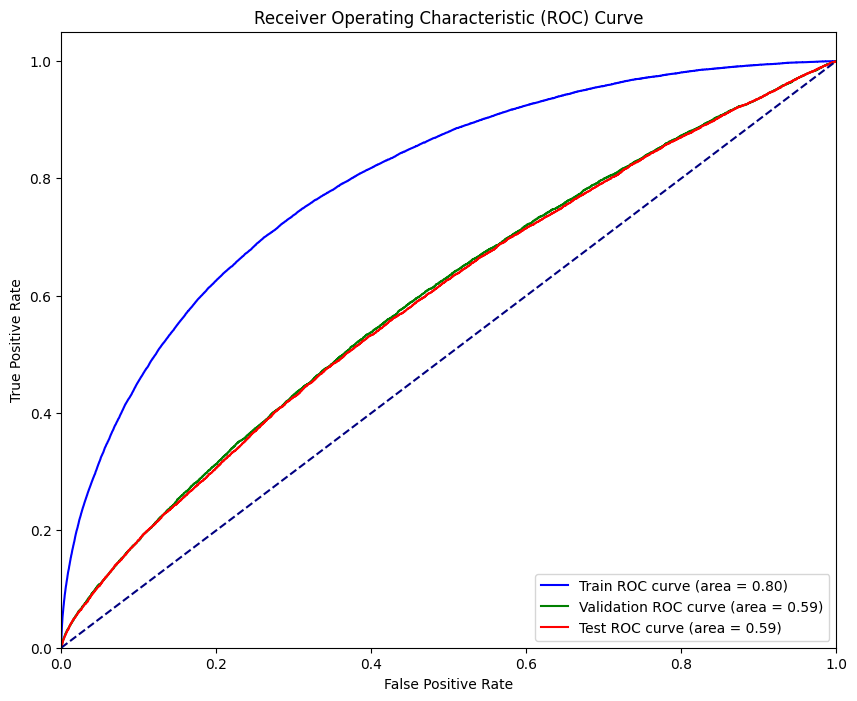

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculate the AUC scores
auc_train = auc(fpr_train, tpr_train)
auc_valid = auc(fpr_valid, tpr_valid)
auc_test = auc(fpr_test, tpr_test)

# Create ROC plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (area = {auc_train:.2f})')
plt.plot(fpr_valid, tpr_valid, color='green', label=f'Validation ROC curve (area = {auc_valid:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC curve (area = {auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


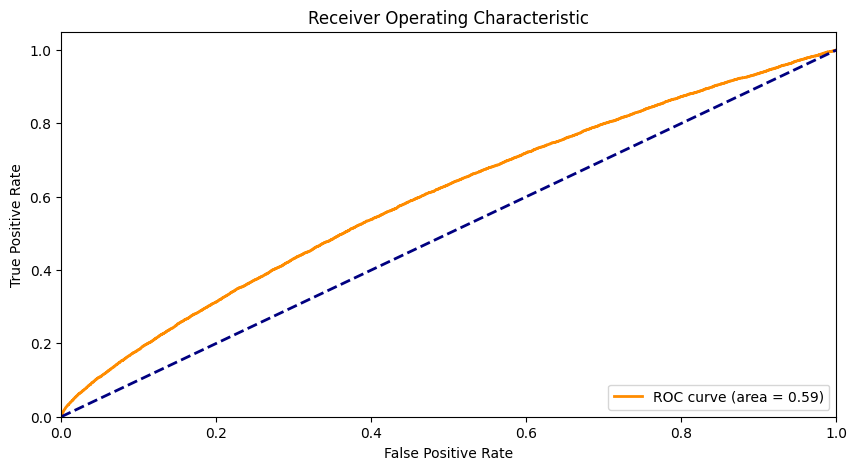

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


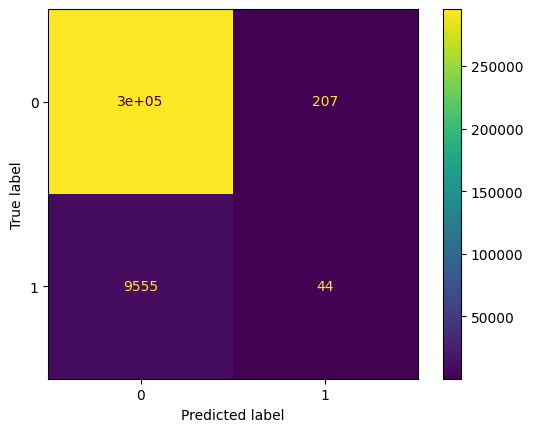

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred > 0.5)  # Using 0.5 as the threshold
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

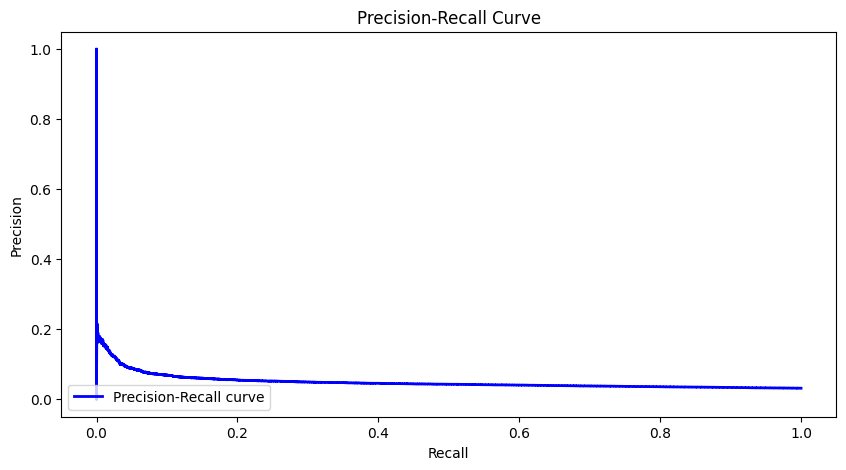

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_valid, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

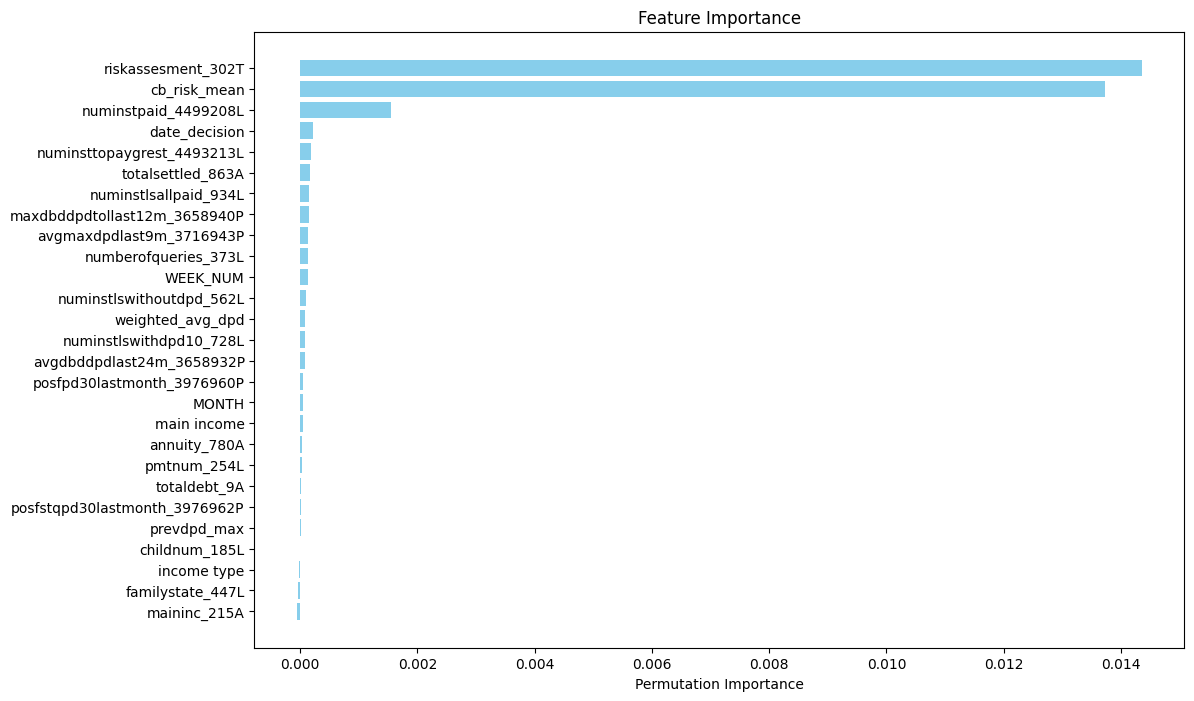

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(full_pipeline, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)

# Organize importances into a DataFrame
perm_importance_df = pd.DataFrame({'features': X_valid.columns, 'importance': result.importances_mean})

# Sort by importance
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['features'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


STABILITY METRIC

In [ ]:
#from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression

In [ ]:
# Function to calculate weekly Gini scores
def calculate_weekly_gini(data, preds, target='target'):
    data['predictions'] = preds
    weekly_gini = data.groupby('WEEK_NUM').apply(
        lambda x: 2 * roc_auc_score(x[target], x['predictions']) - 1
    )
    return weekly_gini.reset_index(name='gini')

# Function to fit linear regression and compute stability metrics
def calculate_stability_metrics(weekly_gini):
    model = LinearRegression()
    weeks = weekly_gini['WEEK_NUM'].values.reshape(-1, 1)
    gini_scores = weekly_gini['gini'].values
    model.fit(weeks, gini_scores)
    a = model.coef_[0]
    predictions = model.predict(weeks)
    residuals = weekly_gini['gini'] - predictions
    falling_rate = min(0, a)
    stability_metric = np.mean(weekly_gini['gini']) + 88.0 * falling_rate - 0.5 * np.std(residuals)
    return stability_metric

# Evaluate the model and compute stability metrics
datasets = [(X_train, y_train, "Training"), (X_valid, y_valid, "Validation"), (X_test, y_test, "Testing")]
for X_set, y_set, label in datasets:
    y_pred = full_pipeline.predict_proba(X_set)[:, 1]
    X_set['WEEK_NUM'] = X_set['WEEK_NUM']  # Ensure WEEK_NUM is in the dataframe if not already
    weekly_gini = calculate_weekly_gini(X_set, y_pred)
    stability_metric = calculate_stability_metrics(weekly_gini)
    auc_score = roc_auc_score(y_set, y_pred)
    print(f'{label} AUC Score: {auc_score}')
    print(f'{label} Stability Metric: {stability_metric}')

Training AUC Score: 0.7963112370103307
Training Stability Metric: 0.5771242154379155
Validation AUC Score: 0.5947242876872081
Validation Stability Metric: 0.10865424030737107
Testing AUC Score: 0.5914501713516093
Testing Stability Metric: 0.11135566300153879


Training AUC Score: 0.7963112370103307
Training Stability Metric: 0.5771242154379155
Validation AUC Score: 0.5947242876872081
Validation Stability Metric: 0.10865424030737107
Testing AUC Score: 0.5914501713516093
Testing Stability Metric: 0.11135566300153879


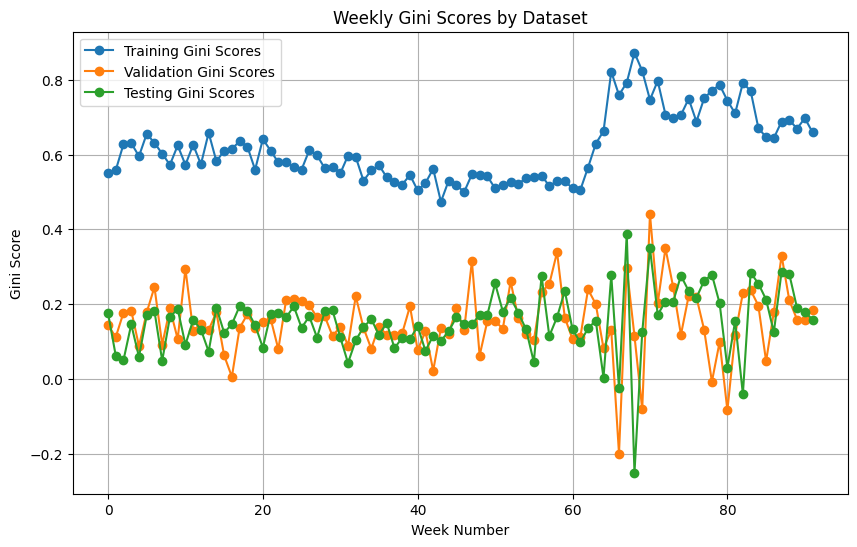

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model and store Gini scores
gini_results = []
datasets = [(X_train, y_train, "Training"), (X_valid, y_valid, "Validation"), (X_test, y_test, "Testing")]
for X_set, y_set, label in datasets:
    y_pred = full_pipeline.predict_proba(X_set)[:, 1]
    weekly_gini = calculate_weekly_gini(X_set.assign(predictions=y_pred), y_pred, target='target')
    stability_metric = calculate_stability_metrics(weekly_gini)
    auc_score = roc_auc_score(y_set, y_pred)
    print(f'{label} AUC Score: {auc_score}')
    print(f'{label} Stability Metric: {stability_metric}')
    gini_results.append((label, weekly_gini))

# Plotting the weekly Gini scores
fig, ax = plt.subplots(figsize=(10, 6))
for label, data in gini_results:
    weeks = data['WEEK_NUM']
    gini_scores = data['gini']
    ax.plot(weeks, gini_scores, marker='o', label=f'{label} Gini Scores')
ax.set_title('Weekly Gini Scores by Dataset')
ax.set_xlabel('Week Number')
ax.set_ylabel('Gini Score')
ax.legend()
plt.grid(True)
plt.show()
